In [17]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os


In [18]:
np.random.seed(111)
torch.cuda.is_available()

True

In [19]:
# Enforcing GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# Loading file paths
#train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
#test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
#RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'
train_path = f'E:/CMAPSS/data/train_FD00X.txt'
test_path = f'E:/CMAPSS/data/test_FD00X.txt'
RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'

labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors

In [21]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    dtype=np.float32))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    dtype=np.float32))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [22]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

In [23]:
# Adding RUL columns 
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

In [11]:
train_data[0]

,unit,cycles,opMode1,opMode2,opMode3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1.0,1.0,-0.0007,-0.0004,100.0,518.669983,641.820007,1589.699951,1400.599976,14.62,...,2388.020020,8138.620117,8.4195,0.03,392.0,2388.0,100.0,39.060001,23.419001,191.0
1,1.0,2.0,0.0019,-0.0003,100.0,518.669983,642.150024,1591.819946,1403.140015,14.62,...,2388.070068,8131.490234,8.4318,0.03,392.0,2388.0,100.0,39.000000,23.423599,190.0
2,1.0,3.0,-0.0043,0.0003,100.0,518.669983,642.349976,1587.989990,1404.199951,14.62,...,2388.030029,8133.229980,8.4178,0.03,390.0,2388.0,100.0,38.950001,23.344200,189.0
3,1.0,4.0,0.0007,0.0000,100.0,518.669983,642.349976,1582.790039,1401.869995,14.62,...,2388.080078,8133.830078,8.3682,0.03,392.0,2388.0,100.0,38.880001,23.373899,188.0
4,1.0,5.0,-0.0019,-0.0002,100.0,518.669983,642.369995,1582.849976,1406.219971,14.62,...,2388.040039,8133.799805,8.4294,0.03,393.0,2388.0,100.0,38.900002,23.404400,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,196.0,-0.0004,-0.0003,100.0,518.669983,643.489990,1597.979980,1428.630005,14.62,...,2388.260010,8137.600098,8.4956,0.03,397.0,2388.0,100.0,38.490002,22.973499,4.0
20627,100.0,197.0,-0.0016,-0.0005,100.0,518.669983,643.539978,1604.500000,1433.579956,14.62,...,2388.219971,8136.500000,8.5139,0.03,395.0,2388.0,100.0,38.299999,23.159401,3.0
20628,100.0,198.0,0.0004,0.0000,100.0,518.669983,643.419983,1602.459961,1428.180054,14.62,...,2388.239990,8141.049805,8.5646,0.03,398.0,2388.0,100.0,38.439999,22.933300,2.0
20629,100.0,199.0,-0.0011,0.0003,100.0,518.669983,643.229980,1605.260010,1426.530029,14.62,...,2388.229980,8139.290039,8.5389,0.03,395.0,2388.0,100.0,38.290001,23.063999,1.0


We can observe, generally, the trend between the sensor readings and the RUL. Although the data is very noisy, the engines are all of the same make but only subject to different arbitrary conditions of wear and tear. We can go through a smaller subset of engine units, say 10 out of the 100. 


In [6]:
def plot_sensor_reading(df, sensor_no):
    plt.figure(figsize=(12, 4))
    for i in df['unit'].unique():
        if (i % 10 == 0):  # 10 engines only (100 in total)
            plt.plot('RUL', sensor_no, data=df[df['unit'] == i].rolling(10).mean())
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(f'Sensor {sensor_no} reading')
    plt.xlabel('Remaining useful life (RUL)')
    plt.show()

In [7]:
# Exploring the correlation of the sensor readings with RUL
trajectory = 0
train_eda = train_data[trajectory]
for i in range(1, 22):
    plot_sensor_reading(train_eda, f'sensor{i}')

NameError: name 'train_data' is not defined

In [24]:
# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


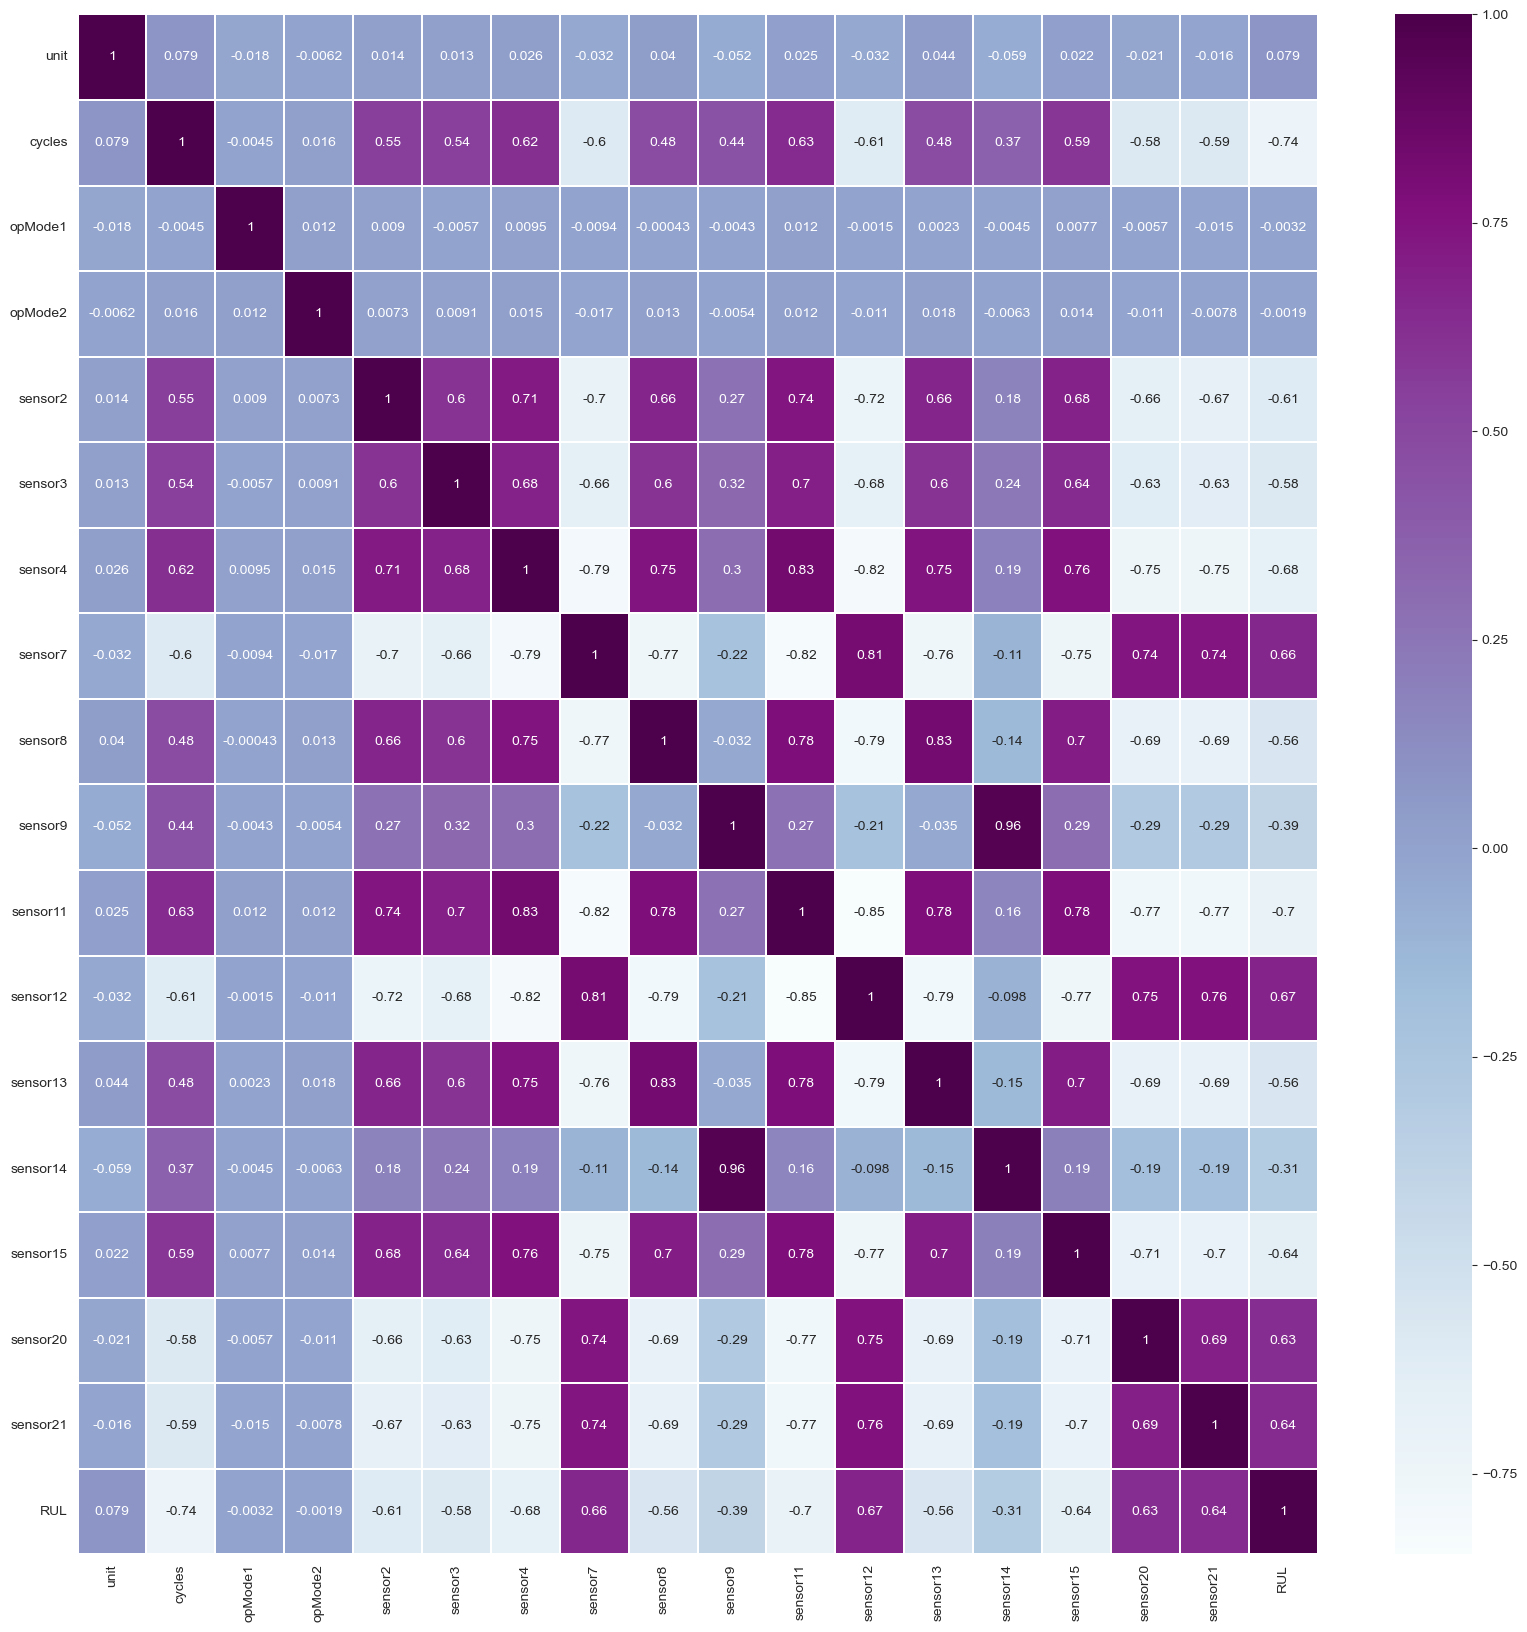

In [25]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [26]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [27]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])

In [28]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [29]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [54]:
sequence_length = 30
trajectory = 0  # see readme file
batch_size = 256

In [31]:
FD001_train = train_data[trajectory]
FD001_test = test_data[trajectory]
FD001_truth = RUL_data[trajectory]

In [56]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [57]:
feature_count = a.shape[1]
out_dim = 1  # output dimension (1 RUL value)

In [58]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.3, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

In [59]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

In [37]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

In [60]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)

~# Model performance functions


In [39]:
def evaluation_metrics(ground_truth, prediction):
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    return None


def loss_graphs(model):
    # expects a tuple of training and validation losses
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Random forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=90, n_jobs=-1, max_features=13, max_depth=10, random_state=42)

# Reshaping 3D tensors for random forest compatibility
x_train_reshaped = x_train.reshape(x_train.shape[0], sequence_length * feature_count)
x_val_reshaped = x_val.reshape(x_val.shape[0], sequence_length * feature_count)
x_test_reshaped = x_test.reshape(x_test.shape[0], sequence_length * feature_count)
start_idx = 2000
end_idx = 2900

truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

rf.fit(x_train_reshaped, y_train)
rf_val_predictions = rf.predict(x_val_reshaped)
print('Validation metrics:')
evaluation_metrics(y_val, rf_val_predictions)

print('\nTest data metrics:')
rf_test_predictions = rf.predict(x_test_reshaped)
evaluation_metrics(truncated_ground_truth, rf_test_predictions)


In [ ]:
from sklearn.model_selection import GridSearchCV

estim = RandomForestRegressor()

# performing grid search for RF regressor
param_grid = {
    'n_estimators': [70, 90, 120],
    'max_depth': [7, 8, 9],
    'max_features': [8, 9, 10]
}

grid = GridSearchCV(estim, param_grid, n_jobs=-1, cv=3)
grid.fit(x_train_reshaped, y_train)
print(grid.best_score_, grid.best_params_)


In [ ]:
# Predict and train using optimised model
rf_final = RandomForestRegressor(n_estimators=70, max_depth=9, max_features=10, random_state=42)
rf_final.fit(x_train_reshaped, y_train)

print('Train data metrics:')
final_train_predictions = rf_final.predict(x_train_reshaped)
evaluation_metrics(y_train, final_train_predictions)

print('\nValidation data metrics:')
final_val_predictions = rf_final.predict(x_val_reshaped)
evaluation_metrics(y_val, final_val_predictions)

print('\nTest data metrics:')
final_test_predictions = rf_final.predict(x_test_reshaped)
evaluation_metrics(truncated_ground_truth, final_test_predictions)


# SVM

In [ ]:
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(x_train_reshaped, y_train) 

In [ ]:
y_svr_train = svr_regressor.predict(x_train_reshaped)
y_svr_test = svr_regressor.predict(x_test_reshaped)
y_svr_val = svr_regressor.predict(x_val_reshaped)

In [ ]:
print('Training data performance: ')
evaluation_metrics(y_train, y_svr_train)
print('\nTest data performance: ')
evaluation_metrics(truncated_ground_truth, y_svr_test)
print('\nValidation data performance: ')
evaluation_metrics(y_val, y_svr_val)

# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [86]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim, dropout_pc, lstm_hs_1=100, lstm_hs_2=50,
                 cnn1_hs=256, cnn2_hs=64, cnn3_hs=32):
        super(DamagePropagationLSTM, self).__init__()
        # Stacked convolutional block
        self.conv1 = nn.Conv1d(in_channels=feature_count, out_channels=cnn1_hs, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(in_channels=cnn1_hs, out_channels=cnn2_hs, kernel_size=5, padding='same')
        self.conv3 = nn.Conv1d(in_channels=cnn2_hs, out_channels=cnn3_hs, kernel_size=5, padding='same')
        self.globalAvgPool1D = nn.AdaptiveAvgPool1d(cnn3_hs)
       
        self.lstm1 = nn.LSTM(input_size=cnn3_hs, hidden_size=lstm_hs_1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_pc)
        self.lstm2 = nn.LSTM(input_size=lstm_hs_1, hidden_size=lstm_hs_2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_pc)
        self.dense2 = nn.Linear(in_features=lstm_hs_2, out_features=out_dim)
        self.activation2 = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.globalAvgPool1D(x)
        #x = x.view(x.size(0), -1)
        
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x
       
   

In [87]:
# training function
def train_model(model, criterion, optimizer, 
                scheduler, train_loader, val_loader, 
                num_epochs=60, patience=10, destination='unnamed_model.pt', verbose=True):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
            
                epoch_val_loss += loss.item() * data.size(0)
                
        
        
        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), destination)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses



In [133]:
lstm_hidden_size_1 = 128
lstm_hidden_size_2 = 64
cnn3_hs=32
cnn2_hs = 96
cnn1_hs = 512
dropout_percentage = 0.2

Model = DamagePropagationLSTM(feature_count, out_dim, dropout_percentage,
                              lstm_hidden_size_1, lstm_hidden_size_2, cnn1_hs,
                              cnn2_hs, cnn3_hs).to(device)

In [134]:
# Loss criterion
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(Model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

In [161]:
root_path = os.getcwd()
model_directory = 'models'
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
model_number = f'cnnlstm_1'
model_path = root_path + os.path.join(f'\{model_directory}', f'lstm_{model_number}.pt')
model_path
epochs = 60

In [162]:

model1 = train_model(Model, criterion, optimizer, scheduler,
                     train_loader, val_loader, num_epochs=epochs, 
                     patience=10, destination=model_path)

Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070...
Epoch 1/60, Training Loss: 297.5782, Validation Loss: 303.5722
Epoch 2/60, Training Loss: 305.7217, Validation Loss: 307.3065
Epoch 3/60, Training Loss: 300.4741, Validation Loss: 302.6222
Epoch 4/60, Training Loss: 286.3029, Validation Loss: 293.9655
Epoch 5/60, Training Loss: 295.6425, Validation Loss: 286.8683
Epoch 6/60, Training Loss: 291.3939, Validation Loss: 291.4066
Epoch 7/60, Training Loss: 278.0453, Validation Loss: 324.8615
Epoch 8/60, Training Loss: 282.6027, Validation Loss: 284.5459
Epoch 9/60, Training Loss: 286.6972, Validation Loss: 304.0889
Epoch 10/60, Training Loss: 281.7409, Validation Loss: 283.6196
Epoch 11/60, Training Loss: 284.2024, Validation Loss: 288.1117
Epoch 12/60, Training Loss: 280.9050, Validation Loss: 269.4285
Epoch 13/60, Training Loss: 276.2022, Validation Loss: 311.2114
Epoch 14/60, Training Loss: 273.4625, Validation Loss: 273.6099
Epoch 15/60, Training Loss: 281.

In [163]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim, dropout_percentage,
                              lstm_hidden_size_1, lstm_hidden_size_2, cnn1_hs,
                              cnn2_hs, cnn3_hs).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (conv1): Conv1d(30, 512, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(512, 96, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(96, 32, kernel_size=(5,), stride=(1,), padding=same)
  (globalAvgPool1D): AdaptiveAvgPool1d(output_size=32)
  (lstm1): LSTM(32, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=1, bias=True)
  (activation2): ReLU()
)

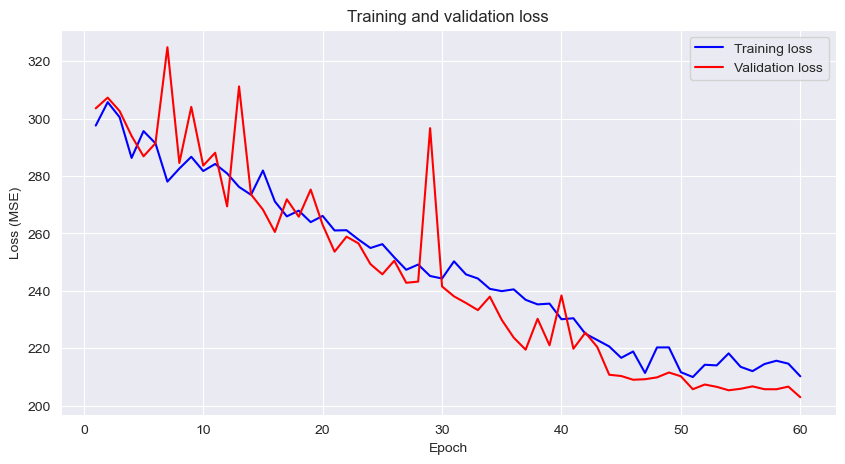

In [164]:
loss_graphs(model1)


### Model evaluation on validation data

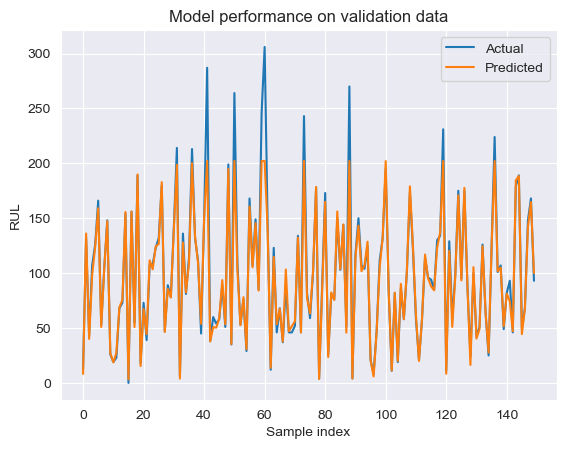

In [165]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).cpu()

# Plotting
plt.plot(y_train[0:150], label='Actual')
plt.plot(y_train_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [166]:
# Validation data test metrics
evaluation_metrics(y_train, y_train_pred)

Mean squared error: 144.7418670654297
Root mean squared error: 12.030871391296387
R2 score: 0.962138922246647
Mean absolute error: 5.54309606552124


# Preparing test data

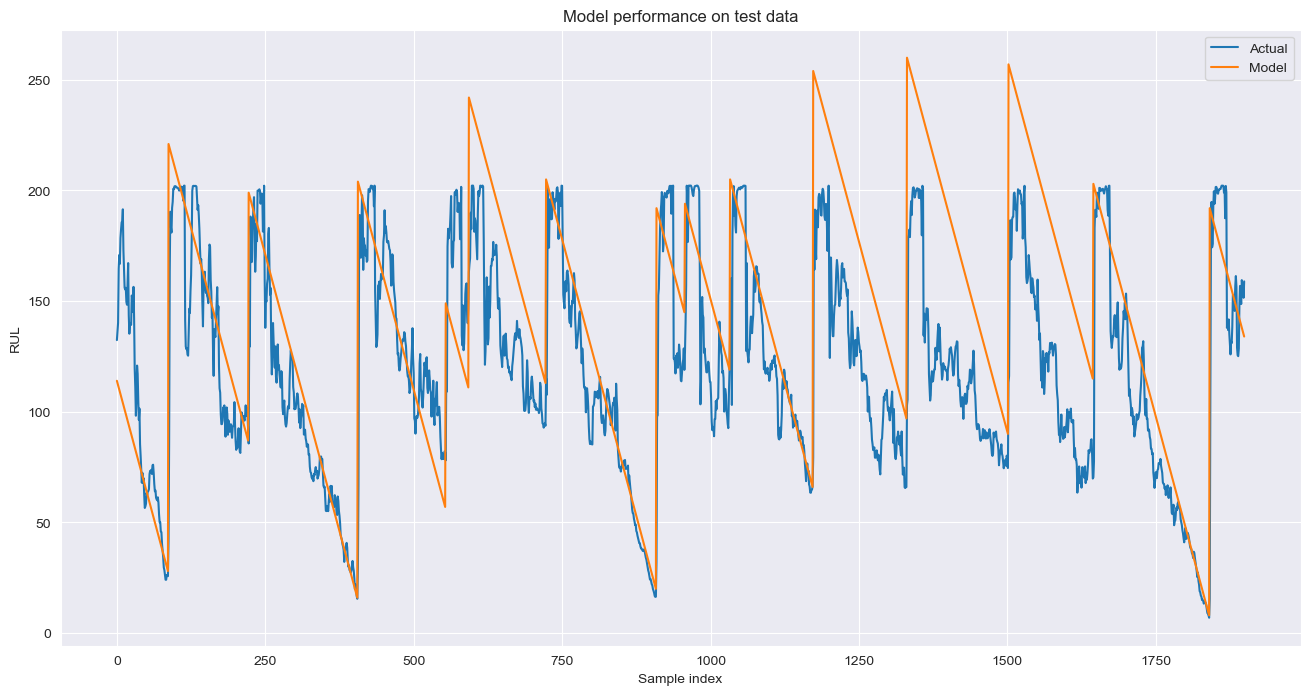

In [167]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)
start_idx = 2000
end_idx = 3900
truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(y_test_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()


In [168]:
# Test data evaluation
evaluation_metrics(truncated_ground_truth, y_test_pred)
print(ModelTest)
print(f"Sequence length: {sequence_length}\nBatch size: {batch_size}")

Mean squared error: 2122.5048828125
Root mean squared error: 46.07065200805664
R2 score: 0.39105814196938316
Mean absolute error: 33.8553466796875
DamagePropagationLSTM(
  (conv1): Conv1d(30, 512, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(512, 96, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(96, 32, kernel_size=(5,), stride=(1,), padding=same)
  (globalAvgPool1D): AdaptiveAvgPool1d(output_size=32)
  (lstm1): LSTM(32, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=1, bias=True)
  (activation2): ReLU()
)
Sequence length: 30
Batch size: 256


# Automatic hyperparameter tuning
There are many hyperparameters that we can tune such as learning rate, batch size, sequence length, hidden sizes of our LSTM units, dropout percentage, etc.


In [75]:
from ray import tune, train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import optuna

In [79]:
# Objective function

def objective(trial):
    # hyperparameter search space
    lstm_hs_1 = trial.suggest_int('lstm_hs_1', 64, 256)
    lstm_hs_2 = trial.suggest_int('lstm_hs_2', 64, 128)
    dropout_pc = trial.suggest_float('dropout_pc', 0.1, 0.4)
    
    # Generate model
    model_to_tune = DamagePropagationLSTM(feature_count=feature_count, out_dim=out_dim,
                                          dropout_pc=dropout_pc, lstm_hs_1=lstm_hs_1,
                                          lstm_hs_2=lstm_hs_2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model_to_tune.parameters(), lr=trial.suggest_float('lr', 1e-4, 1e-2), weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
     
    tuning_performance = train_model(model_to_tune, criterion, optimizer, scheduler,
                    train_loader, val_loader, num_epochs=epochs,
                patience=10, destination=model_path, verbose=False)
    
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    model_to_tune.eval()
    with torch.no_grad():
        tuned_predictions = model_to_tune(x_test_tensor)
    tuned_predictions = torch.Tensor.cpu(tuned_predictions)
    acc = r2_score(truncated_ground_truth, tuned_predictions)
    return acc
        
    

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, n_jobs=1)

print('Best trial:')
trial = study.best_trial

print(' Value: ', trial.value)
print(' Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [190]:
# 30 trials took about 3 hours. so it does not have to be run again we store the best values through hard-coding
temp_hs_1 = 119
temp_hs_2 = 85
temp_dropout = 0.23916875418912822
temp_lr = 0.008830739814062202

best_hs_1 = trial.params['lstm_hs_1']  
best_hs_2 = trial.params['lstm_hs_2']
best_dropout = trial.params['dropout_pc']
best_lr = trial.params['lr']

final_model = DamagePropagationLSTM(feature_count, out_dim, best_dropout,
                                    best_hs_1, best_hs_2).to(device)
final_optimizer = torch.optim.RMSprop(final_model.parameters(), lr=best_lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='min', patience=5)


In [191]:
epochs = 90

final_performance = train_model(final_model, criterion, final_optimizer, scheduler,
                                train_loader, val_loader, num_epochs=epochs,
                                patience=10, destination=model_path)


Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070...
Epoch 1/90, Training Loss: 6257.2200, Validation Loss: 3761.1620
Epoch 2/90, Training Loss: 3040.4985, Validation Loss: 2689.7202
Epoch 3/90, Training Loss: 2026.4100, Validation Loss: 2734.7721
Epoch 4/90, Training Loss: 1654.1588, Validation Loss: 2064.9594
Epoch 5/90, Training Loss: 1452.8657, Validation Loss: 1611.4933
Epoch 6/90, Training Loss: 1373.1988, Validation Loss: 1703.3257
Epoch 7/90, Training Loss: 1340.5475, Validation Loss: 1560.7343
Epoch 8/90, Training Loss: 1343.4994, Validation Loss: 1401.7646
Epoch 9/90, Training Loss: 1252.6047, Validation Loss: 2520.2365
Epoch 10/90, Training Loss: 1263.1265, Validation Loss: 2192.3327
Epoch 11/90, Training Loss: 1212.5873, Validation Loss: 1480.1458
Epoch 12/90, Training Loss: 1208.9502, Validation Loss: 1384.7671
Epoch 13/90, Training Loss: 1220.4288, Validation Loss: 1639.7882
Epoch 14/90, Training Loss: 1220.5969, Validation Loss: 1834.0294
Epoc

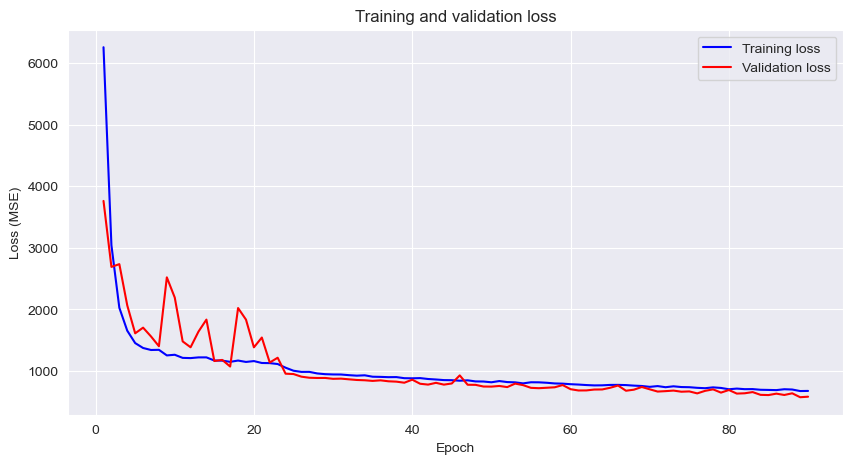

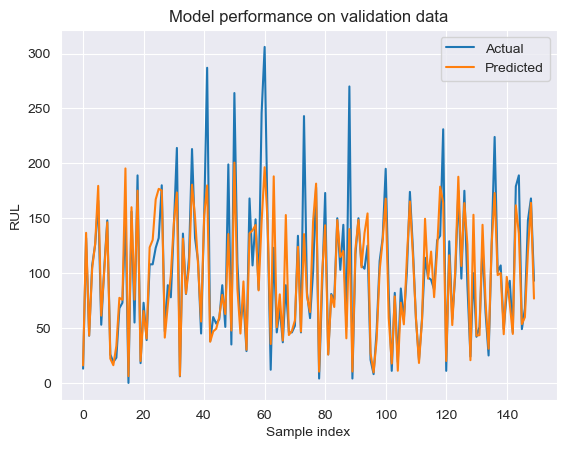

In [192]:
loss_graphs(final_performance)

with torch.no_grad():
    
    y_tuned_pred = final_model(x_train_tensor)
    y_hat_pred = final_model(x_test_tensor)
    
y_tuned_pred = y_tuned_pred.cpu()
y_hat_pred = y_hat_pred.cpu()

plt.plot(y_train[0:150], label='Actual')
plt.plot(y_tuned_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()


In [193]:
evaluation_metrics(y_train, y_tuned_pred)

Mean squared error: 532.2257690429688
Root mean squared error: 23.070018768310547
R2 score: 0.8607822071137642
Mean absolute error: 14.727885246276855


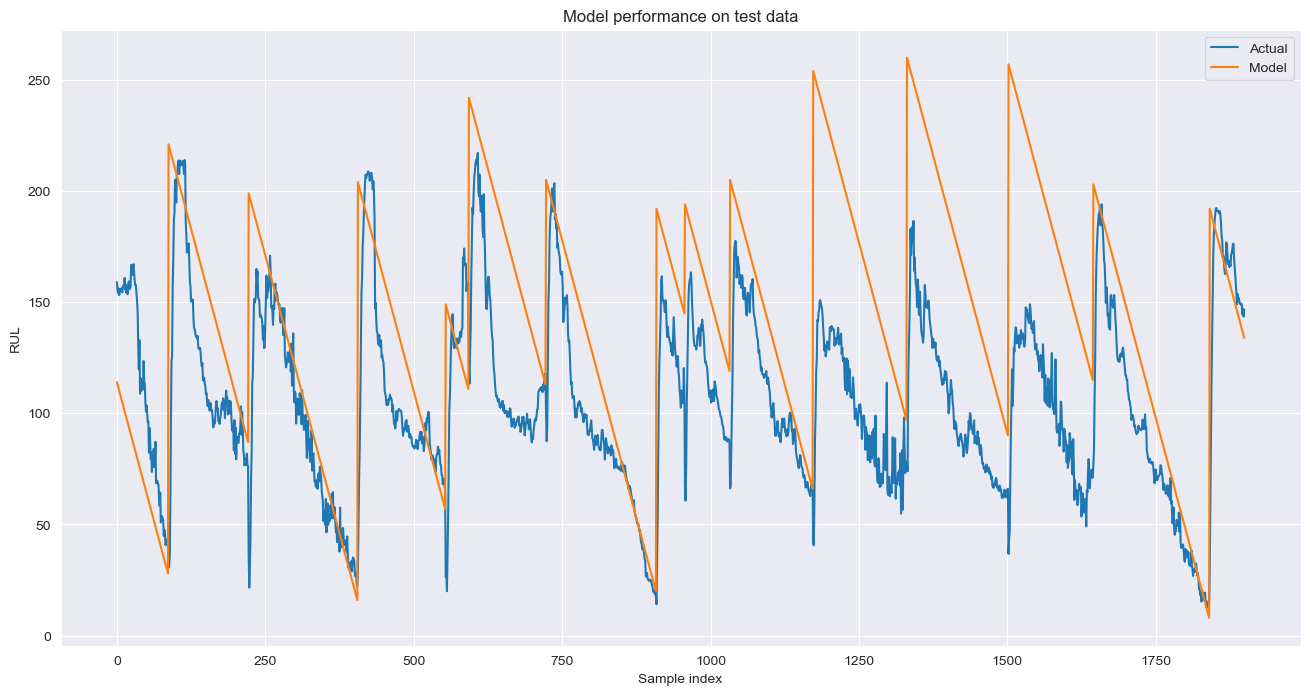

In [194]:
plt.figure(figsize=(16,8))
plt.plot(y_hat_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()

In [195]:
evaluation_metrics(truncated_ground_truth, y_hat_pred)
print(final_model)
print(f"Sequence length: {sequence_length}\nBatch size: {batch_size}")

Mean squared error: 2752.788818359375
Root mean squared error: 52.46702575683594
R2 score: 0.21023112150854018
Mean absolute error: 37.37682342529297
DamagePropagationLSTM(
  (lstm1): LSTM(14, 119, batch_first=True)
  (batch_norm): BatchNorm1d(119, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.23916875418912822, inplace=False)
  (lstm2): LSTM(119, 85, batch_first=True)
  (dropout2): Dropout(p=0.23916875418912822, inplace=False)
  (dense2): Linear(in_features=85, out_features=1, bias=True)
  (activation2): ReLU()
)
Sequence length: 30
Batch size: 256


Exploring the uses of dropout layers in recurrent architectures and how to optimise them.
[1] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7333848&tag=1
Convolutional layer adjustment
[2] https://arxiv.org/pdf/1603.07285v1